In [2]:
#coding:utf-8
import numpy as np
import scipy.stats as sp_stats
import matplotlib.pyplot as plt
from tqdm import tqdm

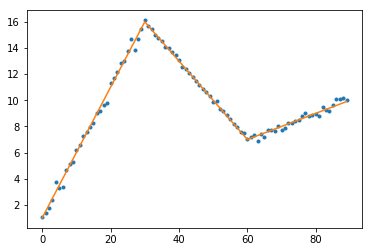

In [3]:
x = np.arange(0,90,1.0)

def yt(t,noise):
    ut = 0
    if 1 <= t <= 30:
        if noise:
            ut = np.random.normal(0,0.3)
        return 1+0.5*t+ut
    elif 31<= t <= 60:
        if noise:
            ut = np.random.normal(0,0.1)
        return 25-0.3*t+ut
    else:
        if noise:
            ut = np.random.normal(0,0.2)
        return 1+0.1*t+ut
    """
    if 0 <= t <= 45:
        if noise:
            ut = np.random.normal(0,0.3)
        return 1+0.5*t+ut
    elif 46 <= t <= 90:
        if noise:
            ut = np.random.normal(0,0.1)
        return 1.0*t-22.5+ut
    """
    """
    if noise:
        ut = np.random.normal(0,0.1)
    return -0.5*t+100+ut
    """
y = [yt(xx,True) for xx in x]
y_true = [yt(xx,False) for xx in x]
plt.plot(x,y,".")
plt.plot(x,y_true)
plt.show()

In [4]:
#データに定数項を吸収させる
xt = np.array([[xx,1] for xx in x])


In [5]:
class ILMM:
    def __init__(self,mu0,V0,Sigma0,n0,tau0,m0,nu0,alpha):
        """const"""
        
        #mu prior
        self.mu0 = mu0
        self.V0 = V0
        self.invV0 = np.linalg.inv(self.V0)
        
        #Sigma prior
        self.nu0 = nu0
        self.Sigma0 = Sigma0
        self.invSigma0 = np.linalg.inv(Sigma0)
        
        
        #sigma_k prioir
        self.n0 = n0
        ##tau piror
        self.m0 = m0
        self.tau0 = tau0
    
        
        self.alpha = alpha
        
    
    def sampling_z(self):
        for t in range(self.N):
            old_k = self.z[t]
            if old_k != -1:
                if self.n[old_k] == 1:
                    del self.n[old_k]
                    del self.Tau[old_k]
                    del self.theta[old_k]
                    del self.sigma[old_k]
                else:
                    self.n[old_k] -= 1
                    self.Tau[old_k].remove(t)
            
            p_z = []
            classes = {}
            _k = 0
            for k in self.n:
                if k==self.new_class:
                    theta = self.sample_gauss(self.mu,self.Sigma)
                    sigma = self.sample_invGamma(self.n0/2.,self.tau/2.)
                    pi = self.alpha
                    new_theta = theta.copy()
                    new_sigma = sigma.copy()
                
                else:
                    theta = self.theta[k]
                    sigma = self.sigma[k]
                    pi = self.n[k]
                p_z.append(self._Gaussian_pdf(self.y[t],sum(theta*self.x[t]),sigma)*pi)
                classes[_k] = k
                _k += 1
            
            p_z = np.array(p_z)
            p_z = p_z/p_z.sum()
            new_k = classes[np.random.multinomial(1,p_z,size=1).argmax()]
            self.z[t] = new_k
            self.n[new_k] += 1
            self.Tau[new_k] += [t]    
            
            if new_k == self.new_class:
                self.theta[self.new_class] = new_theta
                self.sigma[self.new_class] = new_sigma
                j = 0
                while True:
                    if not j in self.n:
                        self.Tau[j] = []
                        self.n[j] = 0
                        self.new_class = j
                        break
                    j += 1
        
    def sampling_theta(self):
        for k in self.n:
            if k != self.new_class:
                tmp1 = np.zeros((2,2))
                tmp2 = np.zeros((2))
                for t in self.Tau[k]:
                    tmp1 += (self.x[t][:,np.newaxis]@self.x[t][:,np.newaxis].T)/self.sigma[k]  
                    tmp2 += (self.y[t]*self.x[t])/self.sigma[k]
                
                Sigma_k =  np.linalg.inv(tmp1+self.invSigma)
                
                mu_k = Sigma_k@(tmp2 + self.invSigma@self.mu)
                self.theta[k] = self.sample_gauss(mu_k,Sigma_k)
    
    def sampling_sigma(self):
        for k in self.n:
            if k != self.new_class:
                tauk = self.tau
                for t in self.Tau[k]:
                    tauk += (self.y[t]-self.theta[k].T@self.x[t])**2
                self.sigma[k] = self.sample_invGamma((self.n0+self.n[k])/2.,tauk/2.)

    
    def sampling_mu(self):
        invV_plus = (len(self.Tau)-1)*self.invSigma+self.invV0
        V_plus = np.linalg.inv(invV_plus)
        
        tmp3 = np.zeros(2)
        for k in self.n:
            if k != self.new_class:
                tmp3 += self.theta[k]
        mu_plus = V_plus@(self.invSigma@tmp3+self.invV0@self.mu0)
        
        self.mu = self.sample_gauss(mu_plus,V_plus)
    
    def sampling_Sigma(self):
        #ν+:1次元
        nu_plus = self.nu0 + len(self.Tau)-1
        
        #Σ+:2*2次元
        tmp4 = np.zeros((2,2))
        for k in self.n:
            if k!= self.new_class:
                tmptmp = (self.theta[k]-self.mu)[:,np.newaxis]
                tmp4 += tmptmp@tmptmp.T
        Sigma_plus = np.linalg.inv(self.invSigma0+tmp4)
        
    
        self.invSigma = self.sample_Wishart(nu_plus,Sigma_plus)
        self.Sigma = np.linalg.inv(self.invSigma)
        
    def sampling_tau(self):
        #m+:1次元
        m_plus = self.m0 + self.n0*(len(self.Tau)-1)
        
        #τ:1次元
        tau_plus = self.tau0 
        for k in self.n:
            if k != self.new_class:
                tau_plus += 1./self.sigma[k]
                
        self.tau = self.sample_Gamma(m_plus/2.,tau_plus/2.)
      
    def _Gaussian_pdf(self,x,mu,Sigma):
        return np.exp(-0.5/Sigma*(x-mu)**2)/np.sqrt(2*Sigma*np.pi) # not normalized
        #return sp_stats.norm.pdf(x,mu,np.sqrt(Sigma))
    
    def sample_gauss(self, mu, Sigma):
        return np.random.multivariate_normal(mean=mu,cov=Sigma)
        
    def sample_invGamma(self,a,b):
        ig = sp_stats.invgamma(a,b)
        return ig.rvs(1)[0]
    
    def sample_Gamma(self, a, b):
        g = sp_stats.gamma(a,b)
        return g.rvs(1)[0]
    
    def sample_Wishart(self, nu, Sigma):
        w = sp_stats.wishart(df = nu, scale = Sigma)
        return w.rvs(1)
    
    def inference(self):
        self.sampling_z()
        self.sampling_theta()
        self.sampling_sigma()
        self.sampling_mu()
        self.sampling_Sigma()
        self.sampling_tau()
                           
    
    def fit(self,x,y):
        #dynamic_variable
        self.x = x
        self.y = y
        
        self.N = self.x.shape[0]
        self.D = self.x.shape[1]
        print(self.N,self.D)
        
        
        self.z = np.ones(self.N)*(-1)
        self.new_class = 0
        self.n = {self.new_class:0}
        self.Tau = {self.new_class:[]}
        
        self.invSigma = self.sample_Wishart(self.nu0,self.Sigma0)
        self.Sigma = np.linalg.inv(self.invSigma)
        
        self.tau = self.sample_Gamma(self.m0/2.,self.tau0/2.)
        self.mu = self.sample_gauss(self.mu0,self.V0)
        
        self.theta = {}
        self.sigma = {}
        
        
        
        

In [6]:
model = ILMM(mu0 = np.array([0,0]),
             V0 = np.eye(2),
             Sigma0 = np.eye(2),
             n0 = 2.0,
             tau0 = 2.0,
             m0 = 2.0,
             nu0 = 3.0,
             alpha = 0.5)
model.fit(xt,y)

90 2


In [7]:
for i in tqdm(range(5000)):
    model.inference()
    

100%|██████████| 5000/5000 [10:57<00:00,  7.99it/s]


In [8]:
model.n

{0: 20, 1: 8, 2: 25, 3: 1, 4: 16, 5: 17, 6: 0, 8: 3}

In [9]:
model.z

array([ 0.,  0.,  0.,  2.,  5.,  4.,  5.,  5.,  0.,  1.,  0.,  2.,  4.,
        4.,  5.,  5.,  2.,  2.,  0.,  0.,  2.,  1.,  2.,  4.,  2.,  5.,
        4.,  5.,  5.,  5.,  5.,  0.,  5.,  0.,  4.,  5.,  0.,  0.,  2.,
        3.,  4.,  5.,  2.,  8.,  5.,  4.,  5.,  4.,  5.,  2.,  2.,  0.,
        2.,  0.,  5.,  8.,  4.,  2.,  1.,  8.,  0.,  2.,  0.,  4.,  2.,
        1.,  0.,  2.,  2.,  4.,  2.,  0.,  1.,  2.,  1.,  2.,  4.,  0.,
        2.,  0.,  1.,  2.,  4.,  2.,  4.,  4.,  1.,  0.,  2.,  2.])

In [10]:
model.Tau

{0: [0,
  1,
  2,
  8,
  10,
  18,
  19,
  31,
  33,
  36,
  37,
  51,
  53,
  60,
  62,
  66,
  71,
  77,
  79,
  87],
 1: [9, 21, 58, 65, 72, 74, 80, 86],
 2: [3,
  11,
  16,
  17,
  20,
  22,
  24,
  38,
  42,
  49,
  50,
  52,
  57,
  61,
  64,
  67,
  68,
  70,
  73,
  75,
  78,
  81,
  83,
  88,
  89],
 3: [39],
 4: [5, 12, 13, 23, 26, 34, 40, 45, 47, 56, 63, 69, 76, 82, 84, 85],
 5: [4, 6, 7, 14, 15, 25, 27, 28, 29, 30, 32, 35, 41, 44, 46, 48, 54],
 6: [],
 8: [43, 55, 59]}

In [11]:
clusters=[]
color_index=[]
for key in model.Tau.keys():
    clusters.append(model.Tau[key])
    color_index.append(key)
    

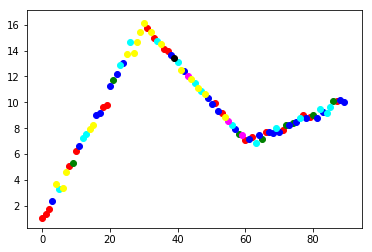

In [12]:
color_list = ["red", "green", "blue", "cyan", "magenta", "yellow", "k","w"]
for i,clu in enumerate(clusters[:8]):
    plt.scatter(clu,[y[i] for i in clu],c=color_list[i])
plt.show()

傾き 0.5 切片1  
傾き-0.3 切片25  
傾き 0.1 切片1  
    

In [13]:
for key in model.theta.keys():
    print(model.theta[key],color_list[color_index.index(key)],model.n[key])

[ 0.15342922  1.98349709] red 20
[ 0.07897136  1.75924905] green 8
[ 0.07151976  2.43619369] blue 25
[ 0.10587349  1.93318947] cyan 16
[ 0.00254307  2.17431018] magenta 3
[ 0.31891174  2.15275279] yellow 17
[ 0.1771724   2.51665438] k 1


In [14]:
print(model.sigma)
for t in range(90):
    print(y[t], sum(model.theta[model.z[t]]*model.x[t]),model.sigma[model.z[t]])
    print([model._Gaussian_pdf(y[t],y[t],model.sigma[k]) for k in [0,1,3,4,5]])

{0: 224.67082467761441, 1: 44.377696968421063, 2: 225.94859416181623, 4: 198.01612238610184, 8: 83.479270531091714, 5: 153.99460194385912, 3: 11.918750778766546}
1.08343959983 1.98349708631 224.670824678
[0.026615628504216726, 0.059886328145877361, 0.11555658436570967, 0.02835043911138202, 0.032148248526978701]
1.3730363455 2.13692630318 224.670824678
[0.026615628504216726, 0.059886328145877361, 0.11555658436570967, 0.02835043911138202, 0.032148248526978701]
1.73975848876 2.29035552004 224.670824678
[0.026615628504216726, 0.059886328145877361, 0.11555658436570967, 0.02835043911138202, 0.032148248526978701]
2.34147641746 2.65075298109 225.948594162
[0.026615628504216726, 0.059886328145877361, 0.11555658436570967, 0.02835043911138202, 0.032148248526978701]
3.71504321898 3.42839975804 153.994601944
[0.026615628504216726, 0.059886328145877361, 0.11555658436570967, 0.02835043911138202, 0.032148248526978701]
3.28744734135 2.46255692135 198.016122386
[0.026615628504216726, 0.05988632814587736